In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/CIS680/Final Project_JZ

/content/drive/.shortcut-targets-by-id/1eo6Q6-D6kQZBGyGfvlcQy4LERzbdtJ0-/Final Project


In [3]:
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
!pip install lpips
!pip install pytorch-fid
from utils import *
from dataset_preload import *
from models import *
from tqdm import tqdm
import torch
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pytorch-fid: filename=pytorch_fid-0.2.1-py3-none-any.whl size=14834 sha256=85d7569626595a10564a253dfb35f0dc4c5946f001b646728894308c4716c94a
  Stored in directory: /root/.cache/pip/wheels/df/c8/a0/cce2ed7671ae52be132ae836e429bba6148544f83b7962b4bc
Successfully built pytorch-fid


### Generate customized dataset

In [ ]:
# Generate training image dataset
img_dir = './data/edges2shoes/train/'
img = []
file_dir = glob.glob(str(img_dir)+'*')
for i in tqdm(range(len(file_dir))):
    image = Image.open(file_dir[i]).resize((256,128))
    image = np.asarray(image).transpose(2,0,1)
    image_tensor = torch.from_numpy(image)
    img.append(image_tensor)
np.savez_compressed('train_img', img)

# Generate validation image dataset
img_dir = './data/edges2shoes/val/'
img = []
file_dir = glob.glob(str(img_dir)+'*')
for i in tqdm(range(len(file_dir))):
    image = Image.open(file_dir[i]).resize((256,128))
    image = np.asarray(image).transpose(2,0,1)
    image_tensor = torch.from_numpy(image)
    img.append(image_tensor)
np.savez_compressed('val_img', img)

### Train

In [5]:
###### Training Configurations ######
img_dir_train = 'data/train_img.npz'
img_dir_val = 'data/val_img.npz'
img_shape = (3, 128, 128)
num_epochs = 65
batch_size = 32
lr_rate = 2e-4			# Adam optimizer learning rate
beta = (0.5, 0.999)     # Beta for optimizer
weight_decay=1e-4		# Adam optimizer weight decay
lambda_pixel = 30       # Loss weights for pixel loss
lambda_latent = 0.5     # Loss weights for latent regression 
lambda_kl = 0.05		# Loss weights for kl divergence
latent_dim = 8			# latent dimension for the encoded images from domain B
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#####################################

# Random seeds (optional)
torch.manual_seed(1)
np.random.seed(1)

# Define DataLoader
train_dataset = Edge2Shoe(img_dir_train, img_shape[-1])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataset = Edge2Shoe(img_dir_val, img_shape[-1])
val_loader = DataLoader(val_dataset, batch_size=1)

# Loss functions
mae_loss = torch.nn.L1Loss().to(device)
mse_loss = torch.nn.MSELoss().to(device)

# Define generator, encoder and discriminators
generator = Generator().to(device)  # GeneratorResNet(input_shape=img_shape,latent_dim=latent_dim).to(device)
encoder = Encoder(latent_dim).to(device)
D_VAE = Discriminator().to(device)
D_LR = Discriminator().to(device)
# Weight initialization
generator.apply(weights_init)
encoder.apply(weights_init)
D_VAE.apply(weights_init)
D_LR.apply(weights_init)

# Define optimizers for networks
optimizer_E = torch.optim.Adam(encoder.parameters(), lr=lr_rate)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_rate)
optimizer_D_VAE = torch.optim.Adam(D_VAE.parameters(), lr=lr_rate)
optimizer_D_LR = torch.optim.Adam(D_LR.parameters(), lr=lr_rate)

# Container for all losses
vae_G_loss_total = []
clr_G_loss_total = []
KL_loss_total = []
img_loss_total = []
latent_loss_total = []
vae_D_loss_total = []
clr_D_loss_total = []

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
###### Training ######
for e in range(num_epochs):
	step = 0
	print("Start training for Epoch %s" % e)
	for idx, data in enumerate(tqdm(train_loader)):
		########## Process Inputs ##########
		edge_tensor, rgb_tensor = data
		edge_tensor, rgb_tensor = norm(edge_tensor).to(device), norm(rgb_tensor).to(device)
		real_A = edge_tensor; real_B = rgb_tensor
		# Divide real A and real B to two parts for separate cVAE and cLR training
		split_index = len(real_A) // 2
		# cVAE-GAN input
		real_A_vae = real_A[:split_index]
		real_B_vae = real_B[:split_index]
		# cLR-GAN input
		real_A_clr = real_A[split_index:]
		real_B_clr = real_B[split_index:]
		# Set gradient flag to training EG and D separately
		D_VAE.requires_grad_(False)
		D_LR.requires_grad_(False)
		generator.requires_grad_(True)
		encoder.requires_grad_(True)

		########## Forward of both cVAE-GAN and cLR-GAN ##########
		### cVAE-GAN ###
		# 1. Encoder takes in B and output Q(z|B)
		mu_vae, logvar_vae = encoder(real_B_vae) # (bz_real, 8)
		# 2. Concatenate A and Q(z|B) for generator to produce B_hat
		z_vae = reparameterization(mu_vae, logvar_vae)
		B_hat_encoded = generator(real_A_vae, z_vae)

		### cLR-GAN ###
		# 1. Get random latent vector z from normal distribution and forward to generator with A to output B_hat
		N_z = torch.randn(real_A_clr.shape[0], latent_dim, device=device)
		B_hat_random = generator(real_A_clr, N_z)
		mu_clr, _ = encoder(B_hat_random)

		########## Train Generator and Encoder ##########
		### Train generator ###
		optimizer_E.zero_grad()
		optimizer_G.zero_grad()
		# Adversarial loss
		fake_B_encoded_label = D_VAE.forward(B_hat_encoded)
		vae_G_loss = mse_loss(fake_B_encoded_label, torch.ones_like(fake_B_encoded_label))
		fake_B_random_label = D_LR.forward(B_hat_random)
		clr_G_loss = mse_loss(fake_B_random_label, torch.ones_like(fake_B_random_label))
		# compute KL loss
		KL_loss = 0.5 * torch.sum(torch.exp(logvar_vae) + mu_vae**2 - logvar_vae - 1, dim=1).mean() * lambda_kl
		# Compute L1 loss
		img_loss = mae_loss(B_hat_encoded, real_B_vae) * lambda_pixel
		# Total generator loss
		loss_G = vae_G_loss + clr_G_loss + KL_loss + img_loss
		loss_G.backward(retain_graph=True)
		# Freeze encoder to not include latent loss
		encoder.requires_grad_(False)
		latent_loss = mae_loss(mu_clr, N_z) * lambda_latent
		latent_loss.backward()
		encoder.requires_grad_(True)
		### Train encoder and generator ###
		optimizer_E.step()
		optimizer_G.step()

		########## Forward Discriminator ##########
		D_VAE.requires_grad_(True)
		D_LR.requires_grad_(True)
		DVAE_real = D_VAE.forward(real_B_vae)
		DVAE_fake = D_VAE.forward(B_hat_encoded.detach())
		DLR_real = D_LR.forward(real_B_clr)
		DLR_fake = D_LR.forward(B_hat_random.detach())

		########## Train Discriminator ##########
		optimizer_D_VAE.zero_grad()
		optimizer_D_LR.zero_grad()
		### Train cVAE-GAN Discriminator ###
		vae_D_total = D_VAE.compute_loss(DVAE_real, DVAE_fake, mse_loss)
		vae_D_total.backward()
		### Train cLR-GAN Discriminator ###
		clr_D_total = D_LR.compute_loss(DLR_real, DLR_fake, mse_loss)
		clr_D_total.backward()
		# Optimize both discriminator
		optimizer_D_VAE.step()
		optimizer_D_LR.step()

		########## Keep record of all losses ##########
		vae_G_loss_total.append(vae_G_loss.item())
		clr_G_loss_total.append(clr_G_loss.item())
		KL_loss_total.append(KL_loss.item())
		img_loss_total.append(img_loss.item())
		latent_loss_total.append(latent_loss.item())
		vae_D_loss_total.append(vae_D_total.item())
		clr_D_loss_total.append(clr_D_total.item())

	#### Save model parameter every 5 epoches ####
	if (e+1) % 5 == 0:
		save_model_state(generator, encoder, D_VAE, D_LR, e)
	#### Save first 20 epoches training plot ####
	if e < 20:
		inference_plot(generator.eval(), val_dataset, device, epoch=e, display=False, n_sample=2, n_show=3)
		generator.train()

#### Save loss ####
torch.save(vae_G_loss_total, 'result/vae_G_loss_total.pth')
torch.save(clr_G_loss_total, 'result/clr_G_loss_total.pth')
torch.save(KL_loss_total, 'result/KL_loss_total.pth')
torch.save(img_loss_total, 'result/img_loss_total.pth')
torch.save(latent_loss_total, 'result/latent_loss_total.pth')
torch.save(vae_D_loss_total, 'result/vae_D_loss_total.pth')
torch.save(clr_D_loss_total, 'result/clr_D_loss_total.pth')

Start training for Epoch 0


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 1


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 2


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 3


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Start training for Epoch 4


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Start training for Epoch 5


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Start training for Epoch 6


100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Start training for Epoch 7


100%|██████████| 10/10 [00:04<00:00,  2.09it/s]


Start training for Epoch 8


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Start training for Epoch 9


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Start training for Epoch 10


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 11


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 12


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Start training for Epoch 13


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 14


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 15


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Start training for Epoch 16


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 17


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 18


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 19


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Start training for Epoch 20


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 21


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 22


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Start training for Epoch 23


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Start training for Epoch 24


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 25


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 26


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 27


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 28


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 29


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 30


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 31


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 32


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 33


100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


Start training for Epoch 34


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 35


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 36


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 37


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 38


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 39


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 40


100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


Start training for Epoch 41


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 42


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 43


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 44


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 45


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 46


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 47


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 48


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 49


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 50


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 51


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 52


100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Start training for Epoch 53


100%|██████████| 10/10 [00:04<00:00,  2.12it/s]


Start training for Epoch 54


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 55


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 56


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 57


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 58


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 59


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 60


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 61


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 62


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


Start training for Epoch 63


100%|██████████| 10/10 [00:04<00:00,  2.13it/s]


Start training for Epoch 64


100%|██████████| 10/10 [00:04<00:00,  2.14it/s]


### Loss

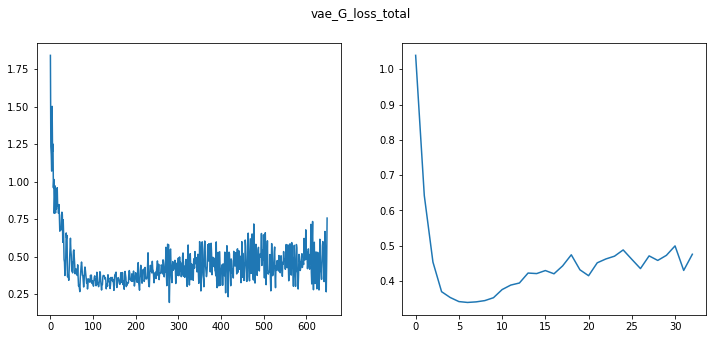

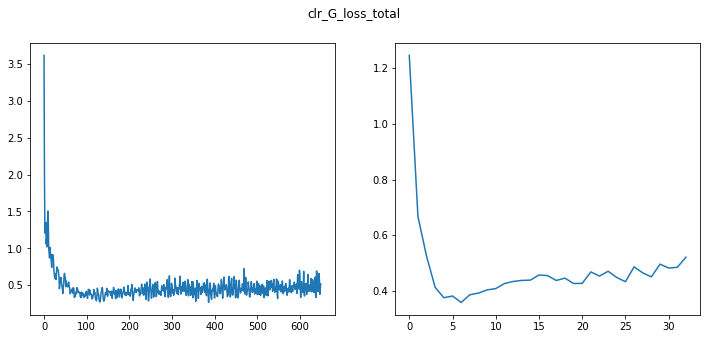

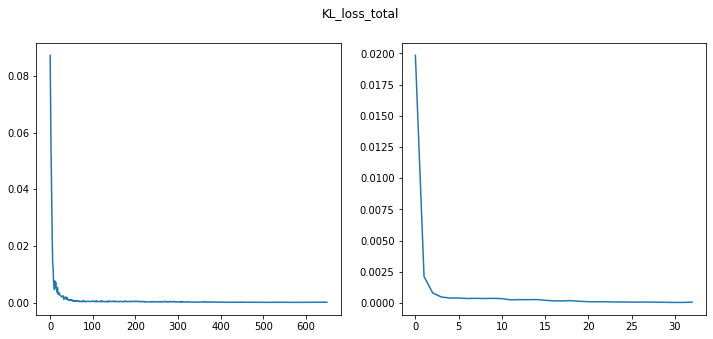

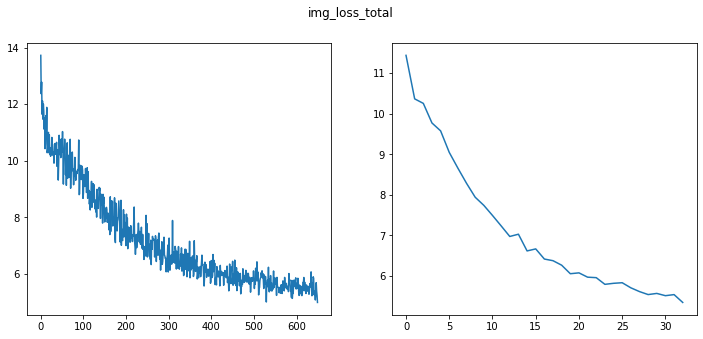

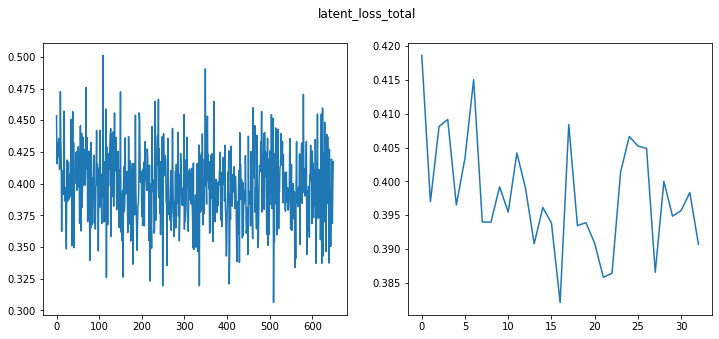

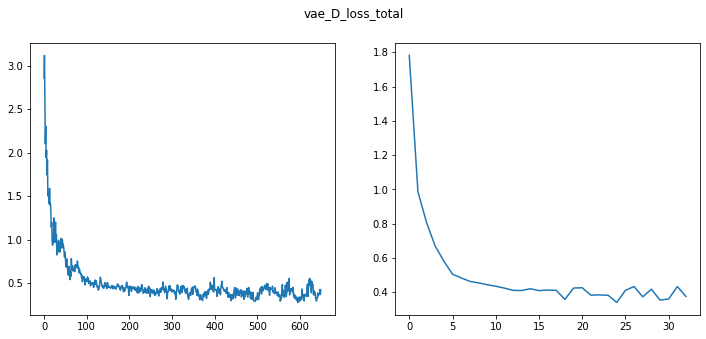

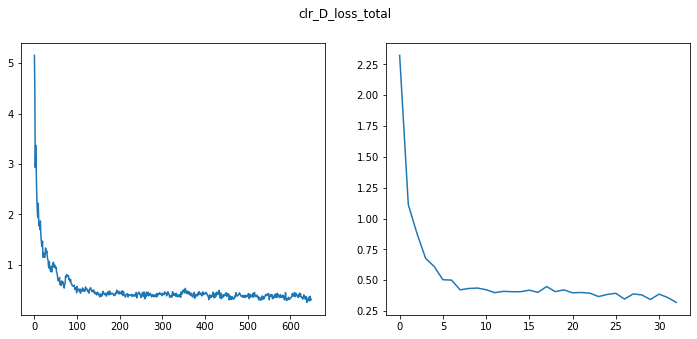

In [ ]:
def loss_plot(loss, title, step=20):
    fig, ax = plt.subplots(1,2,figsize=(12,5))
    smooth_loss = []
    for i in range(0, len(loss), step):
        smooth_loss.append(np.mean(loss[i:i+step]))
    ax[0].plot(loss)
    ax[1].plot(smooth_loss)
    fig.suptitle(title)

loss_plot(vae_G_loss_total, 'vae_G_loss_total')
loss_plot(clr_G_loss_total, 'clr_G_loss_total')
loss_plot(KL_loss_total, 'KL_loss_total')
loss_plot(img_loss_total, 'img_loss_total')
loss_plot(latent_loss_total, 'latent_loss_total')
loss_plot(vae_D_loss_total, 'vae_D_loss_total')
loss_plot(clr_D_loss_total, 'clr_D_loss_total')

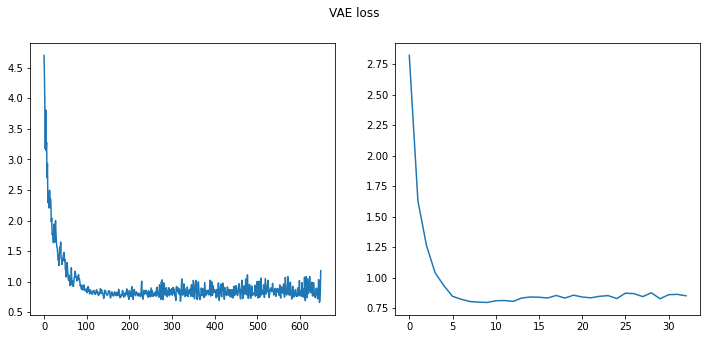

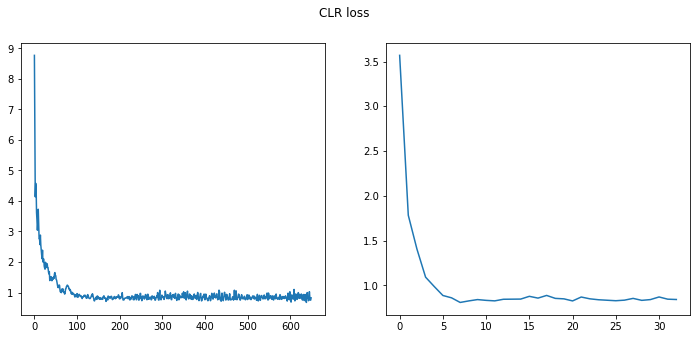

In [ ]:
loss = np.array(vae_G_loss_total) + np.array(vae_D_loss_total)
loss_plot(loss, 'VAE loss')
loss = np.array(clr_G_loss_total) + np.array(clr_D_loss_total)
loss_plot(loss, 'CLR loss')

### Inference plot

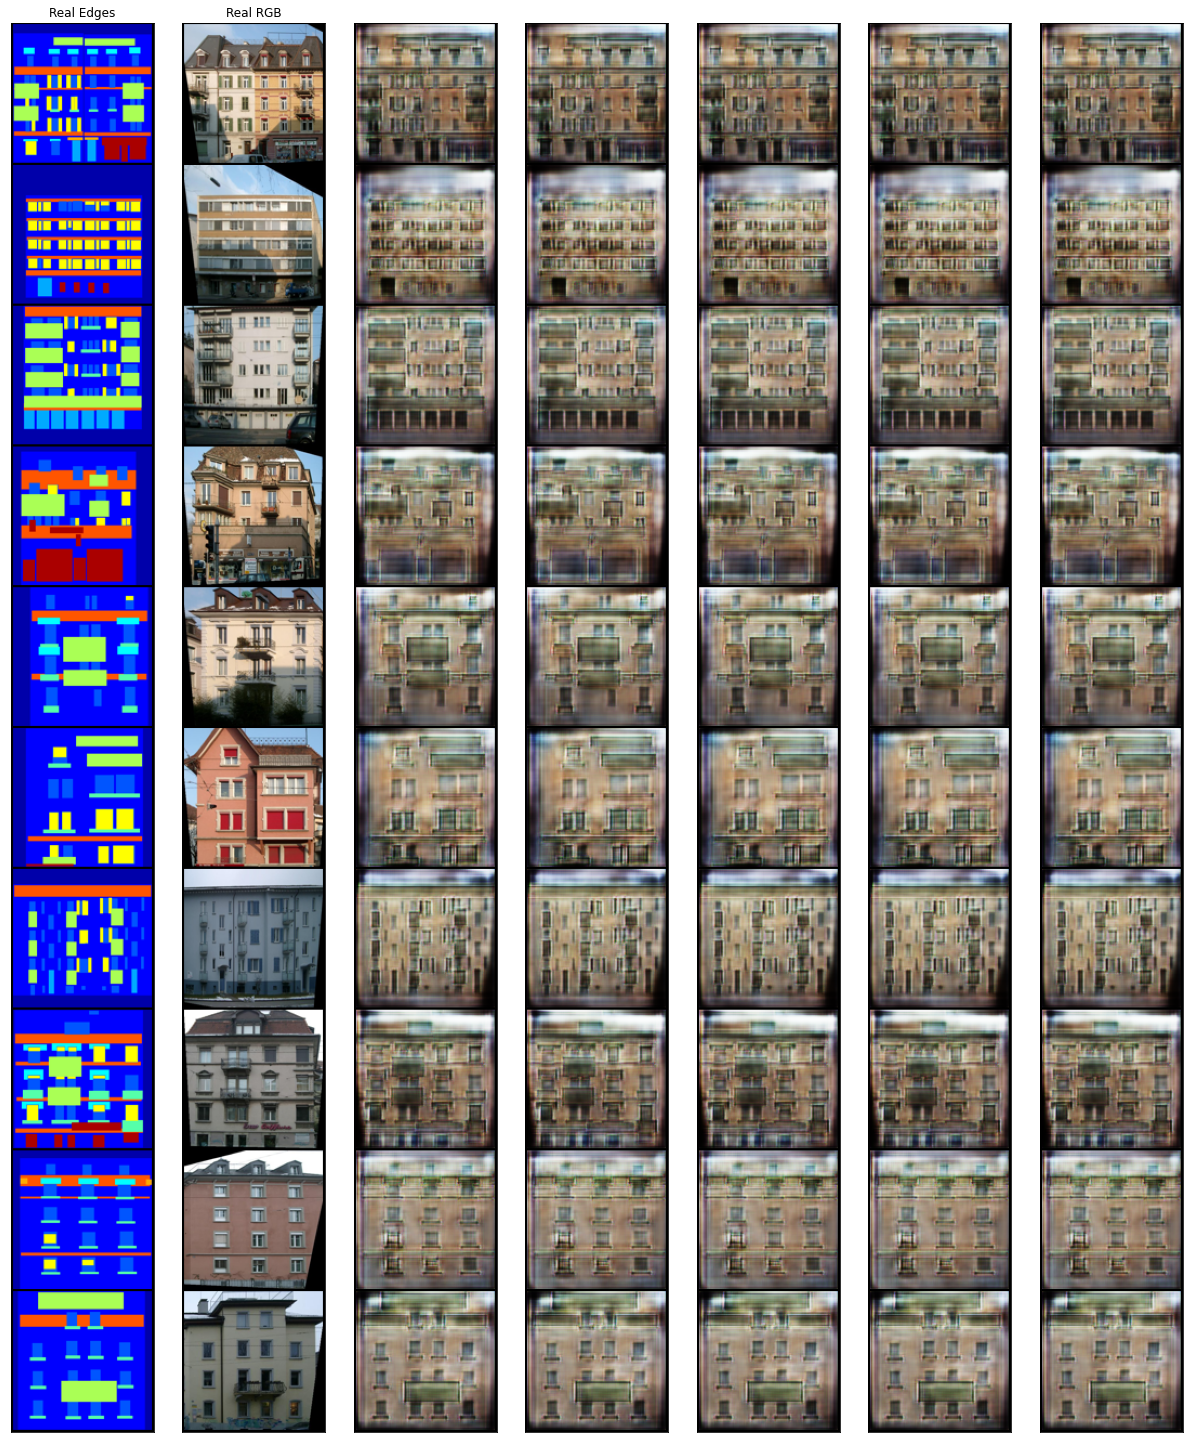

In [ ]:
# Load pre-trained weight
generator = Generator().to(device) # GeneratorResNet(input_shape=img_shape,latent_dim=latent_dim).to(device)
generator.eval()
path = "result/checkpoint/generator-epoch=40.pth"
generator.load_state_dict(torch.load(path))
# Inference plot
torch.manual_seed(423)
inference_plot(generator, val_dataset, device, n_sample=10, n_show=5, start_index=10)

In [ ]:
####### End training session #######
from google.colab import runtime
runtime.unassign()